### Data Exploration

First, the training data is imported and an overall description is provided.  This will give us a high level view of the data, including its span and variance.  The testing dataset is also imported at this stage, but will be held until the model is tested. 

In [66]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import math
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

raw_train_set = pd.read_csv('CBC_3200.csv')
raw_test_set = pd.read_csv('CBC_800.csv')

raw_train_set.head()
%matplotlib inline

The attributes: 'Seq#', "ID#', and 'Gender' are all nominal types as they only show distinction. 'Gender' is binarized with 0=Male and 1=Female. The remaining attributes are ratio types as a value of 0 has an important meaning.  For example, if a customer has a value of 0 for 'ArtBks', this means that they purchased zero books from the art book section-this could influence their probability of purchasing *The Art History of Florence*. If 'M' or 'F' is 0, that equates to the customer spending $0 at the bookstore (or no purchases).  While a value of 0 for 'M' does not exist in this dataset since a customer had to purchase something to be in the database, I would argue that this attribute is ratio. Lastly, 'R' is ratio as this signifies the number of months since a last purchase, a calue of 0 would equate to a purchase being the month the data was collected.

In [2]:
raw_train_set.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Seq#,3200.0,2003.824375,1150.290162,1.0,1015.75,2019.5,2996.25,4000.0
ID#,3200.0,16621.452187,9446.798182,25.0,8387.25,16703.0,24799.50,32977.0
Gender,3200.0,0.703750,0.456674,0.0,0.00,1.0,1.00,1.0
M,3200.0,208.002813,100.440485,15.0,128.00,208.0,284.00,475.0
R,3200.0,13.431875,8.085878,2.0,8.00,12.0,16.00,36.0
F,3200.0,3.780000,3.440065,1.0,1.00,2.0,6.00,12.0
FirstPurch,3200.0,26.277188,18.152209,2.0,12.00,20.0,36.00,99.0
ChildBks,3200.0,0.627188,0.994866,0.0,0.00,0.0,1.00,7.0
YouthBks,3200.0,0.306875,0.617209,0.0,0.00,0.0,0.00,5.0
CookBks,3200.0,0.724063,1.084914,0.0,0.00,0.0,1.00,7.0


In [3]:
print(raw_train_set.shape)

(3200, 18)


The training set has 3200 objects (customers), 17 attributes and 1 class(Florence).  It is also observed that the value span are relatively close, with the exception of 'M', which represents the totalized dollar amount the customer spent at the bookstore. This is important in determining if normalization should be performed.  'Seq#' and 'ID#' will be discussed later. The next step is to see if there is any missing data.

In [4]:
for i in raw_train_set:
    for k in raw_test_set[i].isna().items():
        if k[1]:
            print(True)


Since the above code segment didn't print out True, it is confirmed that there is no missing data in our training dataset. Next, the variables not needed will be removed from the dataset.  This includes 'Seq#' and 'ID#'.  These are not value added as are identification numbers assigned to the customer in the dataset, or the entire customer database the bookstore has. There is no information on how these numbers are assigned, but they are assumed to be sequential in nature.  Since the 4000 customers were randomly selected, there should be no correlation between 'Seq#' and 'ID#' and which books are purchased. 

In [5]:
# with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=FutureWarning)
#     g = sns.pairplot(raw_train_set, hue='Florence', markers=['o','X'])
#     g.fig.set_figheight(16)
#     g.fig.suptitle('Pair plot of dataset', y=1.02)

In [6]:
train_set = raw_train_set.drop(['Seq#', 'ID#'], axis=1)
test_set = raw_test_set.drop(['Seq#', 'ID#'], axis=1)


<Axes: >

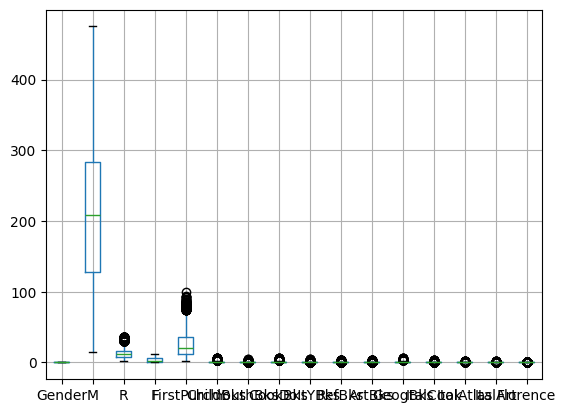

In [7]:
train_set.boxplot()

In [8]:
scalar = MinMaxScaler()
df = pd.DataFrame(scalar.fit_transform(train_set), columns = ['Gender','M','R','F','FirstPurch','ChildBks','YouthBks','CookBks','DoItYBks','RefBks','ArtBks','GeogBks','ItalCook','ItalAtlas','ItalArt','Florence'])
test_df = pd.DataFrame(scalar.fit_transform(train_set), columns = ['Gender','M','R','F','FirstPurch','ChildBks','YouthBks','CookBks','DoItYBks','RefBks','ArtBks','GeogBks','ItalCook','ItalAtlas','ItalArt','Florence'])

<Axes: >

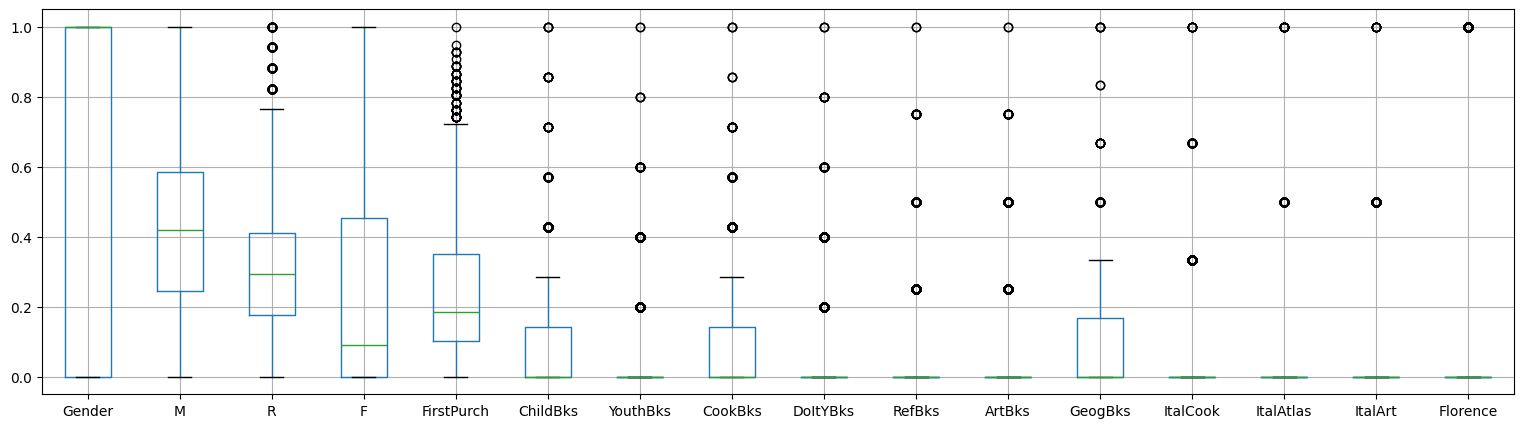

In [9]:
df.boxplot(figsize=(19,5))

<Axes: ylabel='Density'>

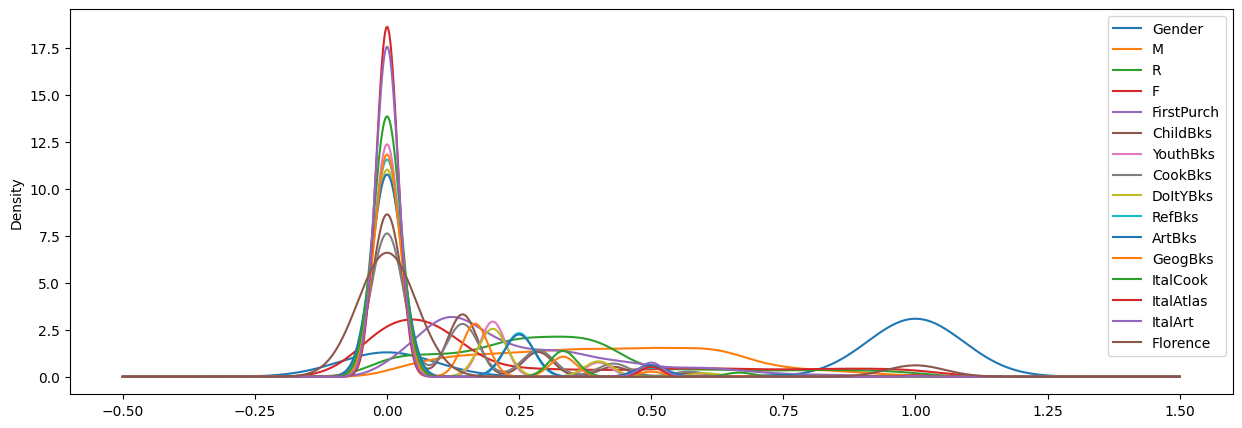

In [10]:
df.plot(kind='density', figsize=(15,5))

In [11]:
# knn = int(math.sqrt(3200))
# nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(df.values)
# distances, indices = nbrs.kneighbors(df.values)

# anomaly_score = distances[:,knn-1]
# print(anomaly_score)

In [12]:
# plt.figure(figsize=(15, 7))
# plt.plot(distances.mean(axis =1))

In [13]:
# dist_stats = pd.DataFrame(distances.mean(axis=1))
# dist_stats.describe()

Support Vector Machine

In [14]:
X_train = df.drop('Florence', axis=1)
y_train = df['Florence']

Text(0, 0.5, 'Accuracy')

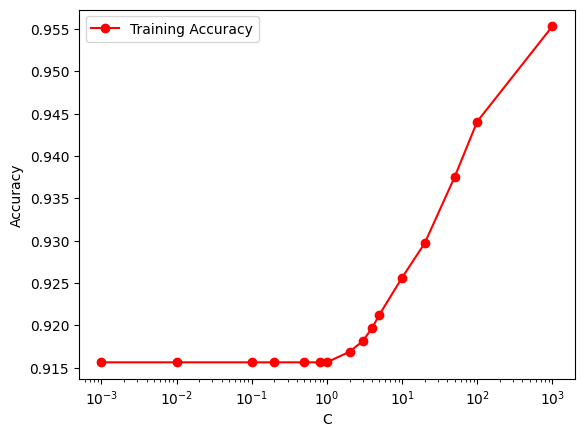

In [15]:
from sklearn.svm import SVC

C = [0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 1,2,3,4, 5, 10, 20, 50, 100, 1000]
SVCtrainAcc = []

for param in C:
    SVCclf = SVC(C=param,kernel='rbf', gamma='scale')
    SVCclf.fit(X_train, y_train)
    Y_predTrain = SVCclf.predict(X_train)
    SVCtrainAcc.append(accuracy_score(y_train, Y_predTrain))

plt.plot(C, SVCtrainAcc, 'ro-')
plt.legend(['Training Accuracy'])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Accuracy')

In [34]:
SVCclf_1 = SVC(C=1,kernel='rbf', gamma='scale', probability=True)
SVCclf_1.fit(X_train, y_train)
Y_predTrain_1 = SVCclf_1.predict(X_train)
accuracy_score(y_train, Y_predTrain_1)


0.915625

In [35]:
scores = cross_val_score(SVCclf_1, X_train, y_train, cv=5)
print(scores)

[0.915625 0.915625 0.915625 0.915625 0.915625]


Testing dataset

In [36]:
X_test = test_df.drop('Florence', axis=1)
y_test = test_df['Florence']

In [37]:
y_predTest_1 = SVCclf_1.predict(X_test)
accuracy_score(y_test, y_predTest_1)

0.915625

Apply over sampling using SMOTE 

In [38]:
print("Before Upsampling: \n", Counter(y_train))
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)
print("After Upsampling: \n", Counter(y_res))

Before Upsampling: 
 Counter({0.0: 2930, 1.0: 270})
After Upsampling: 
 Counter({1.0: 2930, 0.0: 2930})


In [39]:
SVCclf_u = SVC(C=1,kernel='rbf', gamma='scale')
SVCclf_u.fit(X_res, y_res)
Y_predTrain_u = SVCclf_u.predict(X_res)
accuracy_score(y_res, Y_predTrain_u)

0.7078498293515358

In [40]:
y_predTest_u = SVCclf_u.predict(X_test)
accuracy_score(y_test, y_predTest_u)

0.7065625

In [65]:
confusion_matrix(y_test, y_predTest_u)

array([[2070,  860],
       [  79,  191]])

Text(0, 0.5, 'Accuracy')

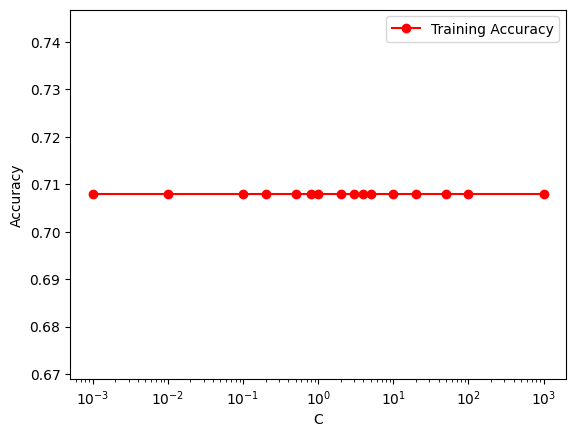

In [41]:
CU = [0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 1,2,3,4, 5, 10, 20, 50, 100, 1000]
SVCtrainAccU = []

for param in CU:
    SSVCclf_u = SVC(C=param,kernel='rbf', gamma='scale')
    SVCclf_u.fit(X_res, y_res)
    Y_predTrain_u = SVCclf_u.predict(X_res)
    SVCtrainAccU.append(accuracy_score(y_res, Y_predTrain_u))

plt.plot(CU, SVCtrainAccU, 'ro-')
plt.legend(['Training Accuracy'])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Accuracy')

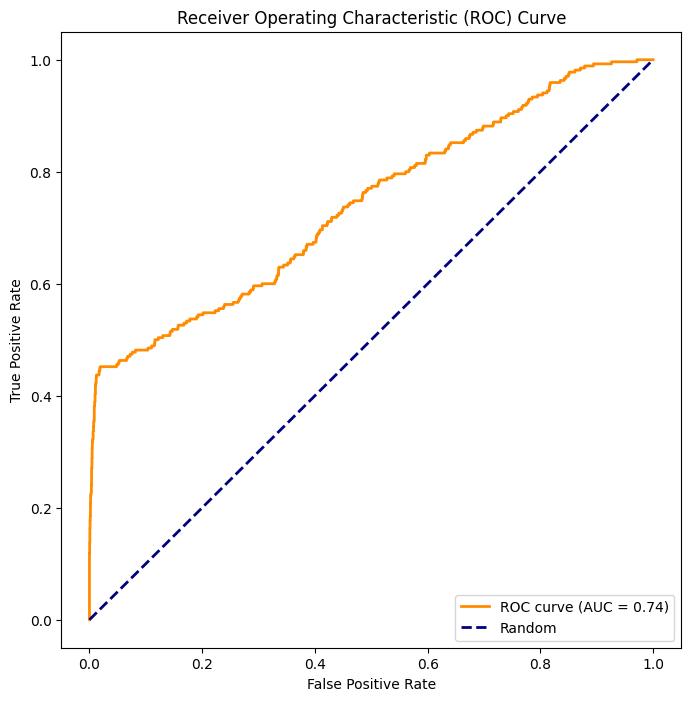

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Predict probabilities on the test set
y_prob = SVCclf_1.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Will use dimensionality reduction https://mikulskibartosz.name/pca-how-to-choose-the-number-of-components

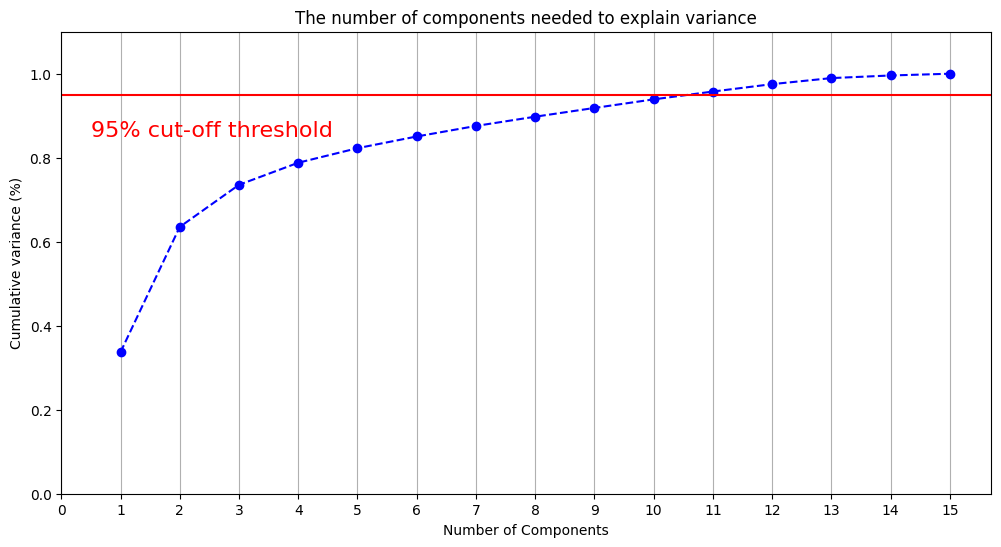

In [55]:
pca = PCA().fit(X_train)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 16, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [57]:
pca = PCA(n_components=11)


In [58]:
X_train_pca = pca.fit_transform(X_train)

In [62]:
SVCclf_s = SVC(C=param,kernel='rbf', gamma='scale')
SVCclf_s.fit(X_train_pca, y_train)
Y_predTrain_s = SVCclf_s.predict(X_train_pca)
accuracy_score(y_train, Y_predTrain_s)


0.961875

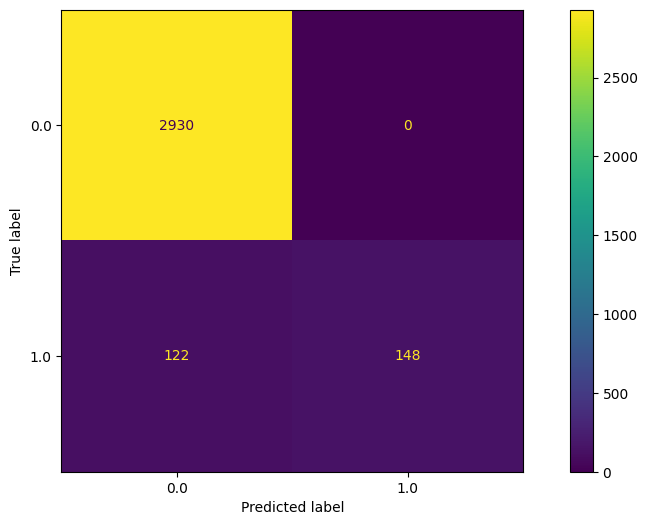

In [68]:
ConfusionMatrixDisplay.from_estimator(SVCclf_s, X_train_pca, y_train)